# Neural Network

## Load Data

In [1]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

## Check Point

In [2]:
# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build Netwrok

In [3]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [4]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    tmp1 = scale * tf.nn.elu(x)
    tmp2 = scale * alpha * (tf.nn.elu(-1*tf.nn.relu(-1*x)))
    return tmp1 + tmp2

In [15]:
class Network(object):
    
    def __init__(self, x_dim, n_classes, p_l1_w, p_l1_b, p_l2_w, p_l2_b, p_l3_w, p_l3_b):
        # Inputs
        self.p_l1_w = p_l1_w
        self.p_l1_b = p_l1_b
        self.p_l2_w = p_l2_w
        self.p_l2_b = p_l2_b
        self.p_l3_w = p_l3_w
        self.p_l3_b = p_l3_b
        self.init_placeholders(x_dim, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, 
            labels=self.y))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim], name='x')
        self.y = tf.placeholder(tf.int64, [None, 10], name='y')
        # dimension: batch_size, x
        self.l1_w = tf.Variable(self.p_l1_w, dtype=tf.float32, name='l1_w')
        self.l1_b = tf.Variable(self.p_l1_b, dtype=tf.float32, name='l1_b')
        self.l2_w = tf.Variable(self.p_l2_w, dtype=tf.float32, name='l2_w')
        self.l2_b = tf.Variable(self.p_l2_b, dtype=tf.float32, name='l2_b')
        self.l3_w = tf.Variable(self.p_l3_w, dtype=tf.float32, name='l3_w')
        self.l3_b = tf.Variable(self.p_l3_b, dtype=tf.float32, name='l3_b')

    def build(self):
        l1_a = selu(tf.nn.bias_add(tf.matmul(self.x, self.l1_w), self.l1_b))
        l2_a = selu(tf.nn.bias_add(tf.matmul(l1_a, self.l2_w), self.l2_b))
        logits = tf.nn.bias_add(tf.matmul(l2_a, self.l3_w), self.l3_b)
        return logits

In [16]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

In [17]:
def truncated_normal(mean=0.0, stddev=0.1, minval=-1.0, maxval=1.0):
    return np.clip(np.random.normal(mean, stddev), minval, maxval)

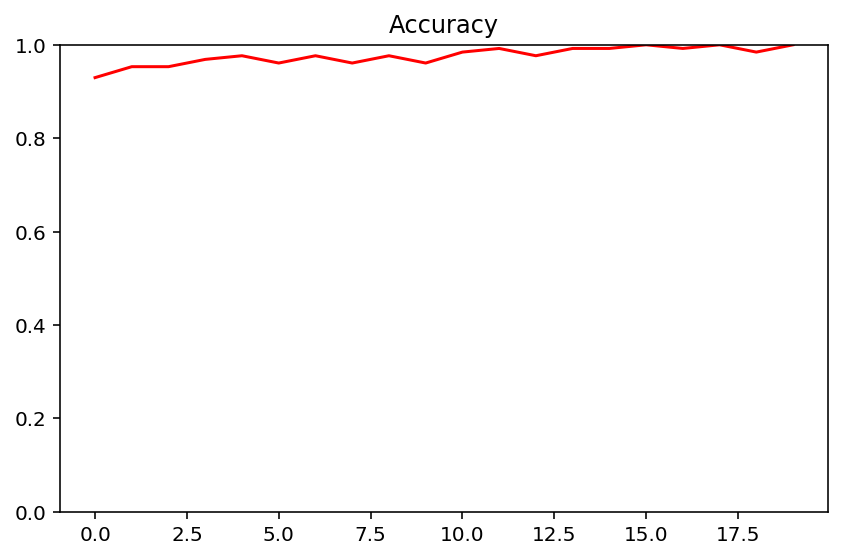

In [19]:
batch_size = 128
x_dim = 784
n_classes = 10
epochs = 20

with tf.Session() as sess:
    
    l1_w = [[truncated_normal() for _ in range(100)] for _ in range(x_dim)]
    l1_b = np.zeros(100)
    l2_w = [[truncated_normal() for _ in range(100)] for _ in range(100)]
    l2_b = np.zeros(100)
    l3_w = [[truncated_normal() for _ in range(10)] for _ in range(100)]
    l3_b = np.zeros(10)

    net = Network(x_dim, n_classes, l1_w, l1_b, l2_w, l2_b, l3_w, l3_b)
    sess.run(tf.global_variables_initializer())
    accuracies = []
    # Initializing the variables
    for e in range(epochs):
        batch_num = mnist.train.num_examples//batch_size
        for ii in range(batch_num):
            train_batch, labels = mnist.train.next_batch(batch_size)
            train_batch = train_batch*2-1

            # Run optimizers
            feed_dict = {net.x:train_batch,
                         net.y:labels}
            _ = sess.run([net.optimizer], feed_dict=feed_dict)
            logits, predict, accuracy = sess.run([net.logits, net.prediction, net.accuracy], feed_dict=feed_dict)
            
        accuracies.append(accuracy)

    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(epochs), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

# Genetic Algorithm

In [20]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from operator import attrgetter
import string
import random
import time

In [21]:
__DEBUG__ = False
batch_size = 64
x_dim = 784
n_classes = 10

In [241]:
class Individual(object):
    
    def __init__(self, generation):
        self.accuracy = -1
        self.evaluation_time = 0.0
        self.generation = generation
                
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 30
        
    def generate(self):
        self.gene = {}
        # l1_w 
        self.gene[0] = np.array([[truncated_normal() for _ in range(100)] for _ in range(x_dim)])
        # l1_b 
        self.gene[1] = np.random.randn(100)
        # l2_w 
        self.gene[2] = np.array([[truncated_normal() for _ in range(100)] for _ in range(100)])
        # l2_b 
        self.gene[3] = np.random.randn(100)
        # l3_w 
        self.gene[4] = np.array([[truncated_normal() for _ in range(10)] for _ in range(100)])
        # l3_b 
        self.gene[5] = np.random.randn(10)
        
    def fitness(self):
        tf.reset_default_graph()
        with tf.Session() as sess:
            net = Network(x_dim, 
                          n_classes,
                          self.gene[0],
                          self.gene[1], 
                          self.gene[2], 
                          self.gene[3],
                          self.gene[4], 
                          self.gene[5])
            sess.run(tf.global_variables_initializer())
            
            values = []
            batch_num = mnist.train.num_examples//batch_size
            for ii in range(batch_num):
                train_batch, labels = mnist.train.next_batch(batch_size)
                # Run optimizers
                feed_dict = {net.x: train_batch,
                             net.y: labels}
                values += sess.run([net.accuracy], feed_dict=feed_dict)
            self.accuracy = np.mean(values)

    def cross_over(self, parent):
        # Complete Continuous Recombination

        child = {}
        for i, g in enumerate(self.gene):
            child[i] = parent.gene[i][:]
        
        for i, g in enumerate(child):
            child[i] = (child[i][:] + parent.gene[i][:])/2.
                    
        individ = Individual(generation=self.generation)
        individ.gene = child
        return individ
        
    def mutate(self, mutation_rate):
        for i, g in self.gene.items():
            for j, v in enumerate(g):
                prob = np.random.sample()
                if prob <= mutation_rate:
                    g[j] = truncated_normal()
            
    def backpropagation(self, backpropagation_momentum):
        prob = np.random.sample()
        if prob <= backpropagation_momentum:
            tf.reset_default_graph()
            with tf.Session() as sess:
                net = Network(x_dim, 
                              n_classes,
                              self.gene[0],
                              self.gene[1], 
                              self.gene[2], 
                              self.gene[3],
                              self.gene[4], 
                              self.gene[5])
                sess.run(tf.global_variables_initializer())

                batch_num = mnist.train.num_examples//batch_size
                for ii in range(batch_num):
                    train_batch, labels = mnist.train.next_batch(batch_size)
                    # Run optimizers
                    feed_dict = {net.x: train_batch,
                                 net.y: labels}
                    _ = sess.run([net.optimizer], feed_dict=feed_dict)
                self.gene[0] = sess.run(net.l1_w)
                self.gene[1] = sess.run(net.l1_b)
                self.gene[2] = sess.run(net.l2_w)
                self.gene[3] = sess.run(net.l2_b)
                self.gene[4] = sess.run(net.l3_w)
                self.gene[5] = sess.run(net.l3_b)
        

In [242]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=.99,
                 backpropagation_momentum=.5):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.backpropagation_momentum = backpropagation_momentum
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 0.0
        self.current_best_individual = None
        self.current_best_solution = 0.0
        self.generation = 0
        self.population = []

    def _evaluate_best_(self):
        self.current_best_individual = self._evaluate_current_best_individual_()
        self.current_best_solution = self.current_best_individual.accuracy
        if self.global_best_individual == None or self.global_best_solution < self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament._evaluate_current_best_individual_()
    
    def _evaluate_current_best_individual_(self):
        return max(self.population, key=attrgetter('accuracy'))
    
    def evaluate_fitnesses(self):
        population_length = len(self.population)
        for i, p in enumerate(self.population):
            if p.accuracy < 0:
                p.fitness()
                print('{}/{}, Accuracy {}'.format(i+1, 
                                                  population_length, 
                                                  p.accuracy))
        self._evaluate_best_()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self.evaluate_fitnesses()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            new_individual.mutate(self.mutation_rate)
            # backpropagation
            new_individual.backpropagation(self.backpropagation_momentum)
            # insert individual
            children_genes.append(new_individual)
        
        self.population = children_genes
        self.generation += 1
    
    def found_solution(self):
        return self.global_best_solution >= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_accuracy(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Solution accuracy: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_solution))    

In [253]:
# hypter-parameters
max_generations = 5
population_size = 50
mutation_rate = 0.05
backpropagation_momentum = 0.2

In [254]:
def execute(max_generations, population_size, mutation_rate, backpropagation_momentum, display_interval=1):
    population = Population(population_size, 
                            max_generations, 
                            mutation_rate=mutation_rate,
                            backpropagation_momentum=backpropagation_momentum)
    population.generate()
    accuracies = []
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_accuracy()
        accuracies.append(population.global_best_individual.accuracy)
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal accuracy: {}, Generation: {}'.format(
        population.generation, 
        best_individual.accuracy, 
        best_individual.generation))
    
    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(len(accuracies)), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
    
    return best_individual, population

1/50, Accuracy 0.09185826778411865
2/50, Accuracy 0.07910724729299545
3/50, Accuracy 0.05957144871354103
4/50, Accuracy 0.11057552695274353
5/50, Accuracy 0.11903376132249832
6/50, Accuracy 0.06259094923734665
7/50, Accuracy 0.10264479368925095
8/50, Accuracy 0.09091240167617798
9/50, Accuracy 0.1510477364063263
10/50, Accuracy 0.08299985527992249
11/50, Accuracy 0.08103536069393158
12/50, Accuracy 0.08138096332550049
13/50, Accuracy 0.09998908638954163
14/50, Accuracy 0.14031577110290527
15/50, Accuracy 0.12379947304725647
16/50, Accuracy 0.09065774083137512
17/50, Accuracy 0.06750218570232391
18/50, Accuracy 0.0704125463962555
19/50, Accuracy 0.10377255827188492
20/50, Accuracy 0.11923384666442871
21/50, Accuracy 0.09111248701810837
22/50, Accuracy 0.14882858097553253
23/50, Accuracy 0.13389478623867035
24/50, Accuracy 0.09551440924406052
25/50, Accuracy 0.10437281429767609
26/50, Accuracy 0.07243160903453827
27/50, Accuracy 0.10069848597049713
28/50, Accuracy 0.028739813715219498
29

29/51, Accuracy 0.9478863477706909
30/51, Accuracy 0.9478499889373779
31/51, Accuracy 0.9245852828025818
32/51, Accuracy 0.9200742244720459
33/51, Accuracy 0.9564173221588135
34/51, Accuracy 0.9138351082801819
35/51, Accuracy 0.9429205656051636
36/51, Accuracy 0.9783905744552612
37/51, Accuracy 0.9745161533355713
38/51, Accuracy 0.9723333716392517
39/51, Accuracy 0.9365359544754028
40/51, Accuracy 0.972187876701355
41/51, Accuracy 0.931388258934021
42/51, Accuracy 0.9705325961112976
43/51, Accuracy 0.9511423110961914
44/51, Accuracy 0.9029940366744995
45/51, Accuracy 0.9630929827690125
46/51, Accuracy 0.8801113367080688
47/51, Accuracy 0.9162907600402832
48/51, Accuracy 0.9598188400268555
49/51, Accuracy 0.9379547238349915
50/51, Accuracy 0.9491596221923828
51/51, Accuracy 0.9542709589004517
Generation: 5/5, Solution accuracy: 0.9783905744552612

Completed 5 generations:
Final accuracy: 0.9783905744552612, Generation: 3


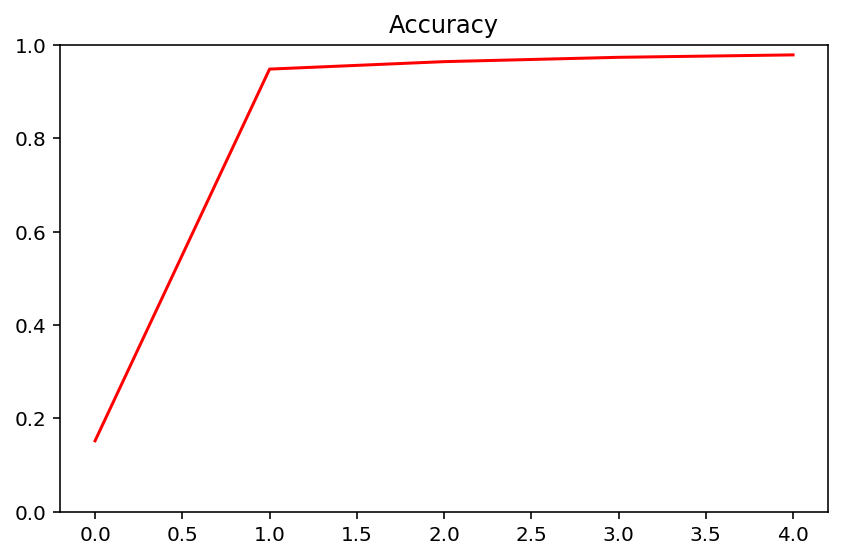

In [255]:
best_individ, population = execute(max_generations, population_size, mutation_rate, backpropagation_momentum)

## Test Model - MNIST

In [256]:
with tf.Session() as sess:
    net = Network(x_dim, 
                  n_classes,
                  best_individ.gene[0],
                  best_individ.gene[1], 
                  best_individ.gene[2], 
                  best_individ.gene[3],
                  best_individ.gene[4], 
                  best_individ.gene[5])
    sess.run(tf.global_variables_initializer())

    values = []
    batch_num = mnist.test.num_examples//batch_size
    for ii in range(batch_num):
        train_batch, labels = mnist.test.next_batch(batch_size)
        # Run optimizers
        feed_dict = {net.x: train_batch,
                     net.y: labels}
        values += sess.run([net.accuracy], feed_dict=feed_dict)
    accuracy = np.mean(values)
    print('Validation accuracy: ', accuracy)

Validation accuracy:  0.965845


## Ensemble
-> not working yet

In [257]:
tf.reset_default_graph()

with tf.Session() as sess:
    
    accuracy = 0.0
    all_predictions = []
    all_labels = []
    
    for p in population.population:
        net = Network(x_dim, 
                      n_classes,
                      p.gene[0],
                      p.gene[1], 
                      p.gene[2], 
                      p.gene[3],
                      p.gene[4], 
                      p.gene[5])
        sess.run(tf.global_variables_initializer())
        
        values = []
        p_labels = []
        batch_num = mnist.test.num_examples//batch_size
        for ii in range(batch_num):
            train_batch, labels = mnist.test.next_batch(batch_size, shuffle=False)
            # Run optimizers
            feed_dict = {net.x: train_batch,
                         net.y: labels}
            values.append(np.argmax(sess.run([net.prediction], feed_dict=feed_dict), 0))
            p_labels.append(labels)
        all_predictions.append(values)
        all_labels.append(p_labels)
    
    correct_pred = np.equal(np.round(np.mean(all_predictions)), all_labels)
    accuracy = np.mean(correct_pred)

    print('Validation accuracy: ', accuracy)

Validation accuracy:  0.9


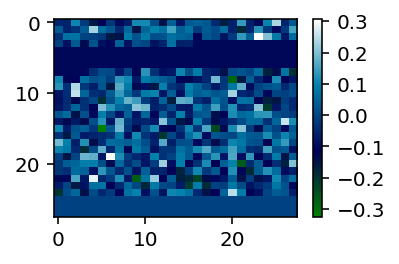

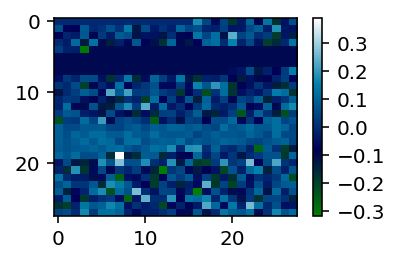

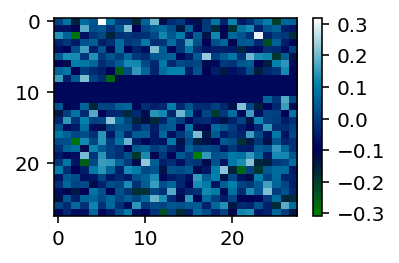

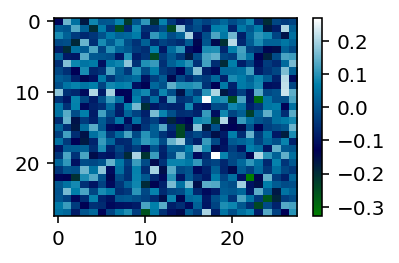

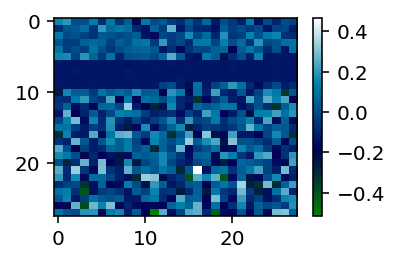

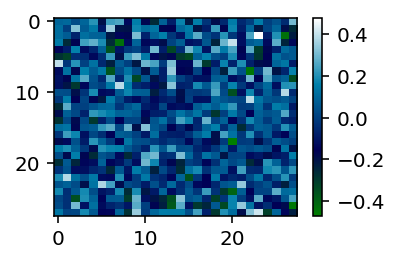

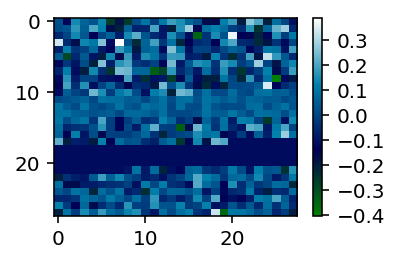

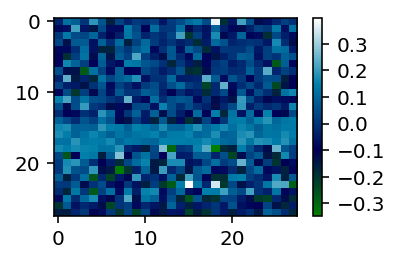

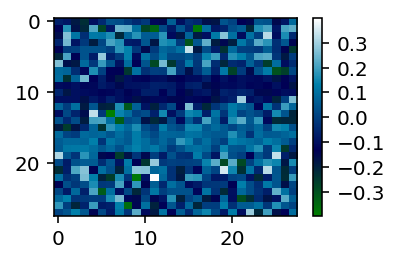

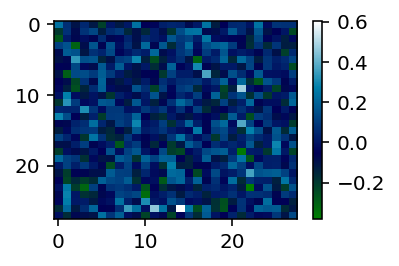

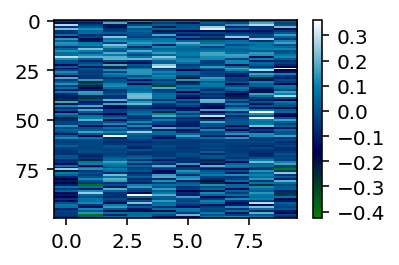

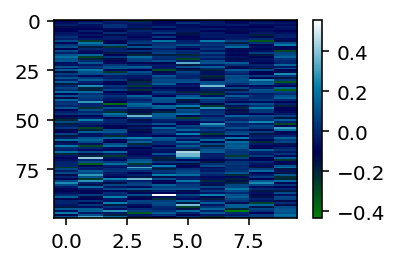

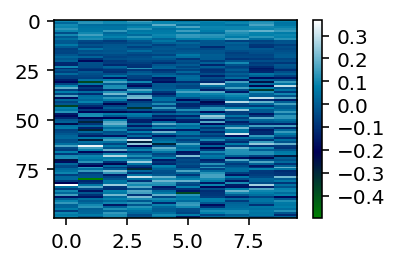

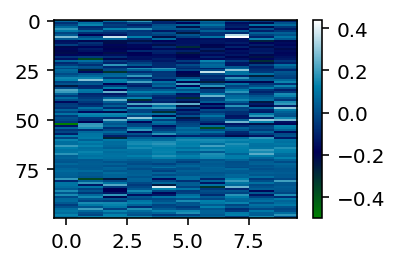

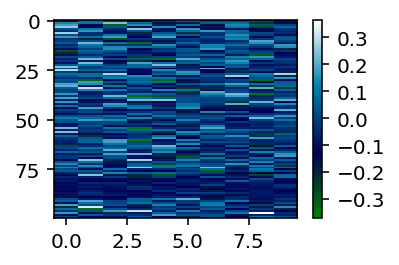

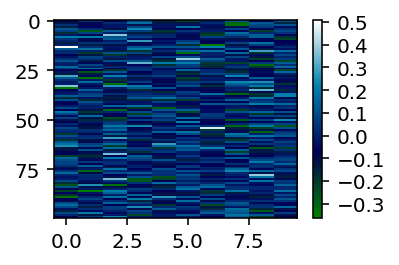

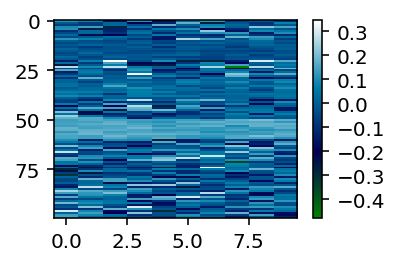

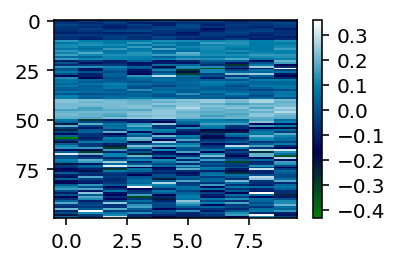

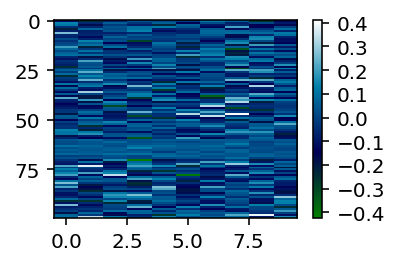

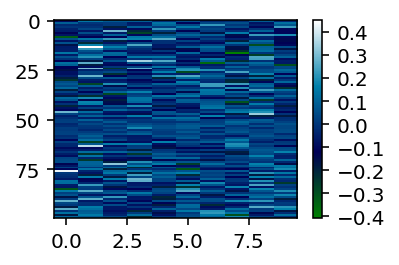

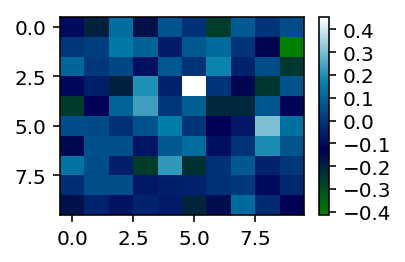

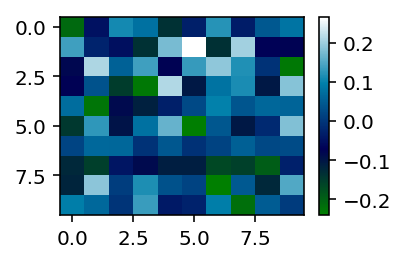

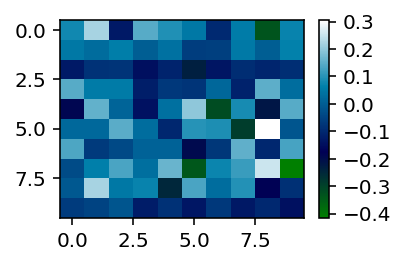

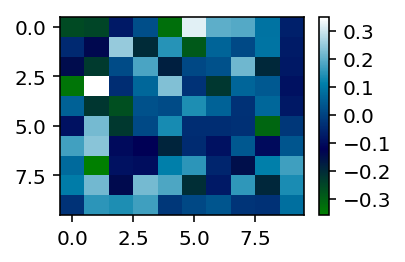

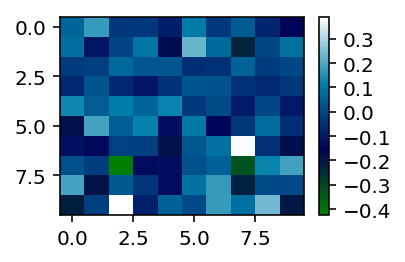

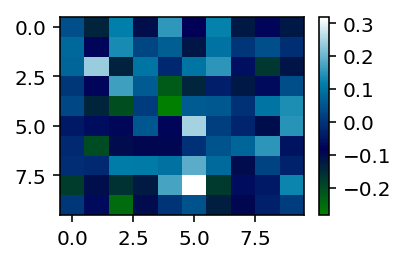

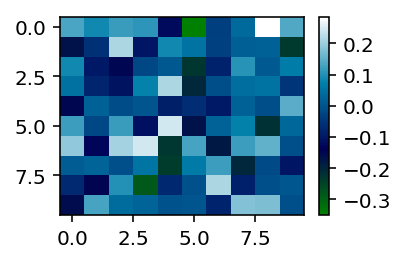

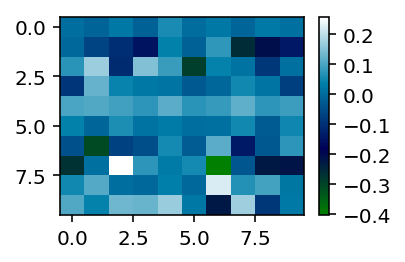

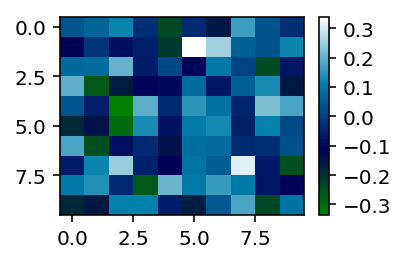

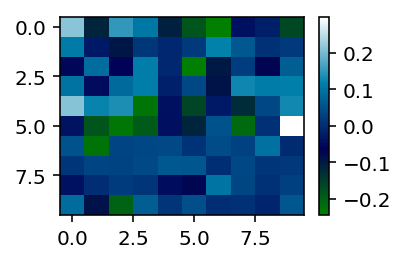

In [258]:
def show_weights(weights_id, weights_shape):
    mat = np.reshape(best_individ.gene[weights_id], weights_shape)

    for ii in range(10):
        acc_plot = plt.subplot(222)
        plt.imshow(mat[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
        plt.colorbar()
        plt.show()

show_weights(0, (-1, 28, 28))
show_weights(2, (-1, 100, 10))
show_weights(4, (-1, 10, 10))

In [259]:
best_individ.gene[2]

array([[ -5.29937446e-02,  -4.37960997e-02,   1.61435325e-02, ...,
         -1.17791735e-01,   2.58657217e-01,  -5.62140532e-02],
       [  3.39262225e-02,  -1.18417807e-01,   1.19297393e-01, ...,
         -1.47169186e-02,   1.02637261e-01,   2.72871703e-02],
       [  1.75243951e-02,  -8.89065489e-02,   1.23911406e-04, ...,
         -2.80821975e-02,  -2.53516525e-01,  -8.89516398e-02],
       ..., 
       [  4.33648974e-02,  -2.49992043e-01,  -1.32033587e-01, ...,
         -1.15068041e-01,   1.68043345e-01,   1.18392728e-01],
       [ -6.35969490e-02,  -1.30415365e-01,   1.58767268e-01, ...,
         -1.18908651e-01,   1.36704341e-01,   5.12390807e-02],
       [  1.54672805e-02,   2.70691723e-01,  -2.99115293e-02, ...,
          1.87984347e-01,   2.89681833e-02,  -6.07133051e-03]], dtype=float32)

## Euclidean Distance Matrix

0


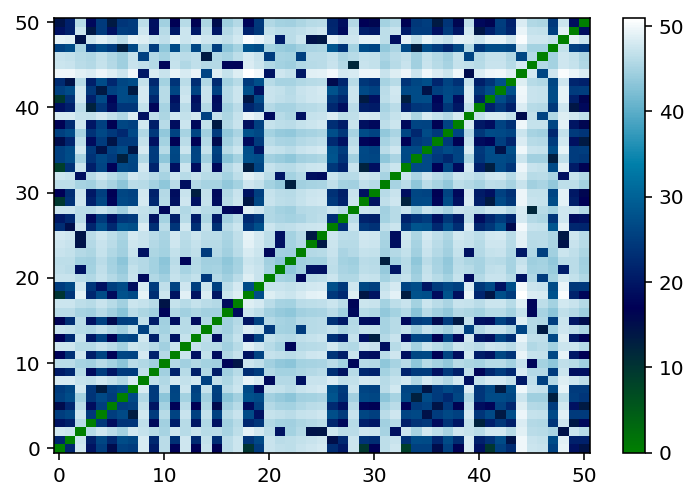

2


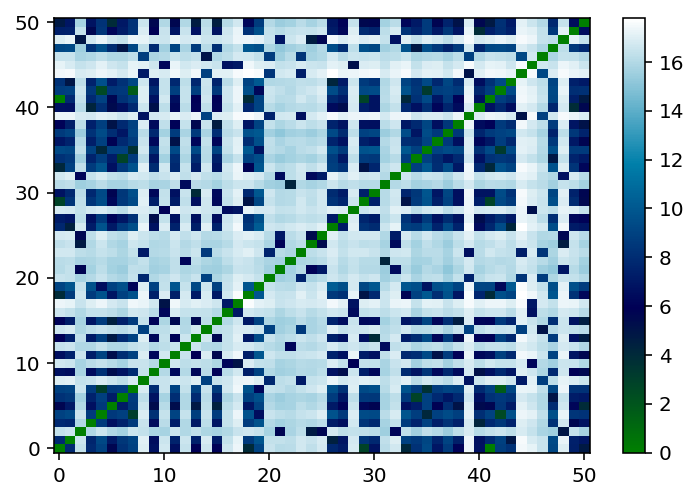

4


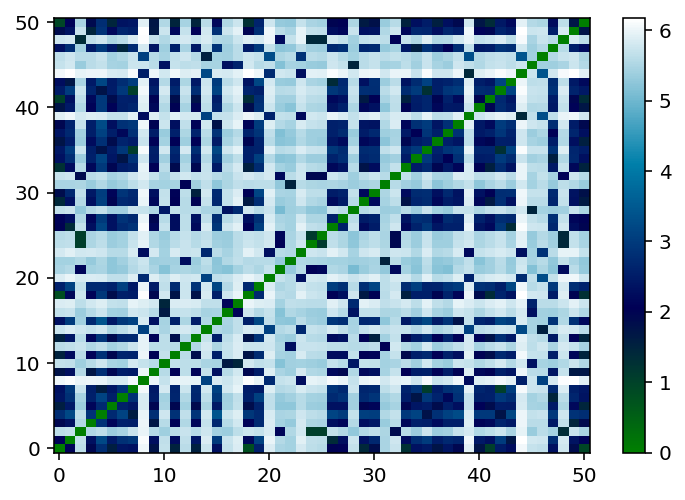

In [262]:
def compute_weights_distance(population, layer_id, layer_shape):
    population_size = len(population)
    distances = np.zeros((population_size, population_size), dtype=np.float32)

    print(layer_id)
    for ii, p in enumerate(population):
        for jj, q in enumerate(population):
            a = np.reshape(p.gene[layer_id], layer_shape)
            b = np.reshape(q.gene[layer_id], layer_shape)
            c = np.power(np.abs(a-b), 2)
            c = np.sum(c)
            c = np.sqrt(c)
            distances[ii, jj] = c

    plt.imshow(distances, interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()
    
compute_weights_distance(population.population, 0, (784, 100))
compute_weights_distance(population.population, 2, (100, 100))
compute_weights_distance(population.population, 4, (100, 10))